Interactive diagnosis framework from genomic data for rare monogenic, recessive disorders using Jupyter notebooks. The underlying motivation is to input mutational data from a patient and interactively assign disease probabilities based on a list of input genes. 

In [29]:
# usual imports
%matplotlib inline
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors 
import seaborn as sns 

# mutational data. This data is from random individuals from the public database of the 1000 genomes project, Phase 3 (ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/release/20130502/)
# The original vcf files were transfored to tsv files with each mutation as a row and various features of the mutation in columns. The features were annotated separately using a in-house tool (VARANT).
df = pd.read_csv('http://godzilla.uchicago.edu/pages/aashish/1000G/1000g-reference-out.TopTranscript.tsv.Unphased.tsv', sep="\t",index_col=False,dtype={'chrom':object})

In [30]:
#The various mutational features
df.columns

Index([u'sample', u'chrom', u'pos', u'ref', u'alt', u'filter', u'qual',
       u'gene', u'region', u'transcript', u'exon', u'cdna', u'mutation',
       u'codon', u'aa_change', u'protein_len', u'splice', u'warning', u'kgaf',
       u'espaf', u'exacaf', u'pp2', u'sift', u'cadd', u'hgmdvar', u'omim_phen',
       u'omim_id', u'clnacc', u'clndbn', u'clndsdb', u'clndsdbid', u'clnhgvs',
       u'clnorigin', u'clnsig', u'gt', u'gq', u'dp', u'model'],
      dtype='object')

In [31]:
#We will focus analysis in a subset of the human genes, known to be associated with rare, monogenic disorders
genes=['ABCA1','ABCA3','AC000111.6','AC005592.2','AC079610.1','AC096669.2','ACO1','ACOX1','ACTA2','AGPS','AGXT','ALDH1L1-AS2','AMACR','ANO10','AP3B1','ATM','ATP2B2','BARD1','C9orf92','CA12','CACNA1B','CAT','CCDC39','CCDC40','CDCA7L','CFH','CFTR','COL3A1','CSF2RA','CSF2RB','CTB-51A17.1','CTC-436P18.1','CTC1','CTD-2008L17.2','CTD-2587H24.5','CUX1','DDX3Y','DHODH','DKC1','DLGAP1','DNAAF1','DNAAF2','DNAH11','DNAH5','DNAH9','DNAI1','DNAI2','DNAL1','DNM1L','DPP8','DYRK1B','EBF2','EFTUD2','EGF','ERCC5','FAM187A','FAN1','FBN1','FOXF1','GNAS','GNPAT','GRB14','HEATR2','HPS1','HPS4','HSD17B4','HYDIN','IDS','IGFBP1','KDM5D','LINC01081','LRRC6','MBIP','MYH11','MYH9','MYLK','MYO3A','NCAM1','NCAM2','NCAPG2','NDE1','NDUFS2','NHP2','NKX2-1','NKX2-1-AS1','NME8','NOP10','NR3C2','NUS1','P2RY8','PEX1','PEX10','PEX11B','PEX12','PEX13','PEX14','PEX16','PEX19','PEX2','PEX26','PEX3','PEX5','PEX6','PEX7','PHYH','POLR1C','POLR1D','PTK2','PTPRU','PUS10','PXDNL','RB1CC1','RERE','RP11-20B7.1','RP11-23E19.1','RP11-354I10.1','RP11-439L18.3','RSPH4A','RSPH9','SCNN1A','SCNN1B','SCNN1G','SCP2','SF3B4','SFTPA2','SFTPB','SFTPC','SLC7A7','SMAD3','SMYD3','SOX6','SRGAP1','TACR1','TAF1C','TBL1Y','TCOF1','TEP1','TERC','TERT','TFRC','TGFB2','TGFBR1','TGFBR2','TINF2','TRERF1','TRIM37','TTC14','UFD1L','VCAN','WRAP53','WRN','ZPLD1']

#This data contains the list of mutations associated with human diseases from HGMD database in the genes above
hgmdclass = pd.read_csv('http://godzilla.uchicago.edu/pages/aashish/1000G/hgmd_snpsindels_Hopkins.diseaseclass.tsv', sep="\t",dtype={'chrom':object})
dfal=pd.merge(df,hgmdclass, how='left', on=['chrom', 'pos', 'ref','alt'])
df=dfal

In [32]:
#cleaning up some of the feature columns
df['kgaf']=df['kgaf'].apply(lambda x: min(map(float,(x.split(',')))))
df['espaf']=df['espaf'].apply(lambda x: min(map(float,(x.split(',')))))
df['exacaf']=df['exacaf'].apply(lambda x: min(map(float,(x.split(',')))))



In [33]:
#further cleanup of a feature column
df['cadd']=df['cadd'].replace(['N,A', '.'], '0')
df['cadd']=df['cadd'].replace([',.'], ',0',regex=True)
df['cadd']=df['cadd'].replace(['.,'], '0,',regex=True)
df['cadd']=df['cadd'].apply(lambda x: max(map(float,(x.split(',')))))

# We focus our analysis on only those mutations that can potentially alter the protein. Only non-protein altering mutations allowed should have a high CADD score > 23.0 (tool for predicting mutational impact)
mutationskeep=['StopGain', 'NonFrameShiftDelete' ,'FrameShiftInsert', 'NonSyn',  'StartGain', 'FrameShiftDelete', 'StartLoss', 'SpliceDonor' ,'SpliceAcceptor' , 'Close_to_SpliceAcceptor', 'Close_to_SpliceDonor']
crit1 = df['exon'].map(lambda x: x.startswith('E'))
crit2 = df['mutation'].map(lambda x: x in mutationskeep)
crit3 = df['splice'].map(lambda x: x in mutationskeep)
crit4 = df['cadd'] > 24.0

#The dataframe is filtered based on the protein-altering and high-CADD mutations
df=df[crit1 | crit2 | crit3 | crit4]

In [34]:
#Some methods for scoring the mutations based on different features. High scores for the variants mean they could be more likely to be damaging/disease-causing.

#Classify the mutation according to population frequency. If very rare (MAF<0.01) in 1000 genomes, the mutation gets a high score (1.0). Mutations with MAF>0.05 get a score of 0.0 
def classifyMAF(s):
    kgaf = s['kgaf']
    exacaf = s['exacaf']
    espaf = s['espaf']
    if kgaf <= 0.01:
        return 1.0
    elif kgaf > 0.01 and kgaf <= 0.05:
        return 0.5
    else:
        return 0.0

#If in the list of genes defined earlier, it gets a score of 1.0, else 0.0. 
def classifyGene(s):
    gene = str(s['gene'])
    if genes.index(gene) < 73:
        return 1
    else:
        return 0.5
    
#If the mutation was called by all three variant callers, it gets a score of 1.0, else 0.0. 
def classifyCaller(s):
    ug = s['gt']
    hc = s['gt']
    pl = s['gt']
    nocall=("0/0" or "./.")
    if hc != "0" and ug != "0" and pl != "0":
        return 1
    else:
        return 0.5
    
#If the mutation was classified as damaging by all SIFT, CADD and Polyphen, it gets a score of 1.0. If by any, a score of 0.5. Else 0.0. 
def classifyPathogenicity(s):
    sift = s['sift']
    pp2 = s['pp2']
    cadd = s['cadd']
    if pp2.startswith("PP2D_") and sift.startswith("D_") and cadd > 15:
        return 1.0
    elif pp2.startswith("PP2D_") or sift.startswith("D_") or cadd > 15:
        return 0.5
    else:
        return 0.0
    
potentiallof=["StartGain","StopGain","StartLoss","StopLoss","FrameShiftInsert","FrameShiftDelete","NonFrameShiftInsert","NonFrameShiftDelete"]
splicevars=["SpliceAcceptor","SpliceDonor","Close_to_SpliceAcceptor","Close_to_SpliceDonor"]
nonsyn=["NonSyn"]

#is the mutation in the UTR region?
def isUTR(s):
    mut=s["mutation"]
    #print mut
    if s["exon"].startswith("E") and mut not in (potentiallof + nonsyn):
        return True
    else:
        return False

#If the mutation is severe protein altering, it gets a score of 1.0. If only nonsynonymous, score 0.5, else 0.25 (i.e. for CADD intronic)
def classifyMuttype(s):
    mutation=s['mutation']
    splice=s['splice']
    #print mutation,splice
    if (mutation in (potentiallof)) or (splice in splicevars):
        return 1.0
    elif mutation in nonsyn:
        return 0.5
    else:
        return 0.25
    
#If the mutation is annotated as high quality(HQ) by the variant callers, score 1.0, else 0.0    
def classifyQuality(s):
    qual=s['qual']
    filt=s['filter']
    #print mutation,splice
    if qual == "HQ":
        return 1
    else:
        return 0

#If the mutation is present in known disease databases, score 1.0. If HGMD is not certain on severity(DM?), score as 0.75 
def classifyDatabase(s):
    clnsig=s['clnsig']
    hgmd=s['hgmdvar']
    hgmddc=s['dc']
    #filt=s['filter']
    if hgmd == "Y" and hgmddc=='DM':
        return 1.0
    elif hgmd == "Y" and hgmddc=='DM?':
        return 0.75
    else:
        return 0.0

#If the patient carries two mutations in a particular gene (i.e. recessive inheritance), score 1.0. Else score 0.5
def classifyInheritance(s,dfv):
    genev=s['gene']
    samplev=s['sample']
    ug = s['gt']
    hc = s['gt']
    pl = s['gt']
    
    totalgene=len(dfv[(dfv['gene']==genev) & (dfv['sample']==samplev)].index)
    if homozygous(ug) or homozygous(hc) or homozygous(pl) or totalgene > 1:
        return 1.0
    else:
        return 0.5


In [35]:
#more methods 
#Defining homozygous and heterozygous variants.
gts=['gt']
df.fillna('0', inplace=True)

def homozygous(genotype):
    if genotype=="0" or genotype=="nan" or genotype=="":  
        genotype='0/0'
    x=genotype.split("/")
    if x[0] != "0" and x[1] != "0":
        return True
    
def heterozygous(genotype):
    if genotype=="0" or genotype=="nan" or genotype=="": 
        genotype='0/0'
    x=genotype.split("/")
    if x[0] != x[1]:
        return True
    else: return False

#compare a list of mutations to see if they are all the same. If any homozygous, the union will be homozygous too and is returned
def alleq(givenlist):
    homval='0/0'
    hetval='0/0'
    for i in givenlist:
        if heterozygous(i): 
            hetval=i
        elif homozygous(i): 
            homval=i
    if homval != '0/0': return homval
    else: return hetval

#combining the frequency values from the different databases. Take the lowest, basically.
df['any.MAF']=df[['kgaf','espaf','exacaf']].apply(lambda x: x.min(), axis=1) 

#combining the mutation calls from different callers
df['any.GT']=df[gts].apply(alleq,axis=1)

/lab/64/app/python/python_aashish/my_py/lib/python2.7/site-packages/IPython/kernel/__main__.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/lab/64/app/python/python_aashish/my_py/lib/python2.7/site-packages/IPython/kernel/__main__.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [36]:
#Count the total number of homozygous and heterozygous genotypes in a list
def genocount(geno):
    homcount=0
    hetcount=0
    for i in geno:
      #  print i
        g=i.split("/")
        if i != "0":
            if g[0] != "0"  and g[1] != "0":
                homcount += 1
            if g[0] == "0" or g[1] == "0" :
                hetcount += 1
    return homcount,hetcount

def genolistcount(genolist):
    for i in genolist:
        print genocount(str(i))

        

def listgt(gqlist,thres):
    return all(i >= thres for i in gqlist)


Next, we define a method that takes in various parameters for the mutational filters and applies them across all the genes and samples to produce distribution of samples which have either 0,1 or > 1 genes that could be carrying disease-causing mutations. The processed data is also passed onto a new dataframe df3, which will later be used to interactively generate a matrix of sample/disease probabilities.

In [37]:
df3=pd.DataFrame()
df['ac']=df['kgaf']*100
from collections import Counter

#This method generates a pie chart of the number of samples with 0,1 or >1 gene matches. A gene is a match if for that sample it might be carrying disease-causing mutations
def genpie( MAFdatabase, MAFthres, CallerGenotype, GQthres, ACthres, MutationTypes):
    callergq=['gq']
    
    # Filtering the original dataframe based on various input parameters and thresholds 
    df2=df[(df[MAFdatabase] < MAFthres) & \
               ((df['mutation'].isin(MutationTypes)) | (df['splice'].isin(MutationTypes))) & \
          (df['ac'].astype(int) < ACthres)]

   
    df2.is_copy=False
         
    # In the filtered dataframe df2, apply the different scoring methods based on the relevant features. Add those scores for each mutation to new columns
    df2['cMAF']=df2.apply(classifyMAF,axis=1)
    df2['cCaller']=df2.apply(classifyCaller,axis=1)
    df2['cGene']=df2.apply(classifyGene, axis=1)
    df2['cPathogenicity']=df2.apply(classifyPathogenicity, axis=1)
    df2['cMuttype']=df2.apply(classifyMuttype,axis=1)
    df2['cQuality']=df2.apply(classifyQuality,axis=1)
    df2['cDatabase']=df2.apply(classifyDatabase,axis=1)
    df2['cInheritance']=df2.apply(classifyInheritance,args=(df2,),axis=1)
        
    
    samples=df2.groupby("sample")
   
    #This calulates the number of gene matches in the filtered dataframe df2 
    tots={}
    for sample,cols in samples:
       # print cols
        x=cols.groupby('gene')[CallerGenotype].apply(genocount)
        tot=0
        for i in x:
            #print sample,i
            if int(i[0]) > 0:
                tot+=1
            if int(i[1]) > 1:
                tot+=1
       # print sample,tot
        if tot>1: tot=2
        tots[sample]=tot
    
    #plot the gene matches distribution for all the samples in a pie chart
    c=Counter(tots.values())
    colors = ['yellowgreen', 'lightskyblue', 'lightcoral']
    plt.rcParams['font.size'] = 40.0
    plt.rcParams['xtick.labelsize']=40.0
    total=sum(c.values())
    fig, axs = plt.subplots(nrows=2, figsize=(40, 16))
    axs[0].pie(c.values(),labels=c.keys(), colors=colors, autopct=lambda(p): '{:.0f}'.format(p * total / 100), shadow=True, startangle=90)
    axs[0].axis('equal')
    
    #Linearly show for each sample the number of gene matches
    axs[1].imshow(np.vstack([tots.values(),tots.values()]),interpolation='None',cmap=plt.cm.bwr)
    zeromatch=[samp for samp, val in tots.items() if val == 0]
    onematch=[samp for samp, val in tots.items() if val == 1]
    twomatch=[samp for samp, val in tots.items() if val > 1]
    
    #Store and pass on the filtered dataframe to df3 for use outside the method
    global df3
    df3=df2


/lab/64/app/python/python_aashish/my_py/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


This is the first sample interactive filtering step. The IPython interactive widgets can be leveraged to select the different filters (e.g. reference population database, types od mutations, etc), while the corresponding thresholds for the quality and frequency can be set by the user as well. This is a quick way to check the robustness of the various parameters. 

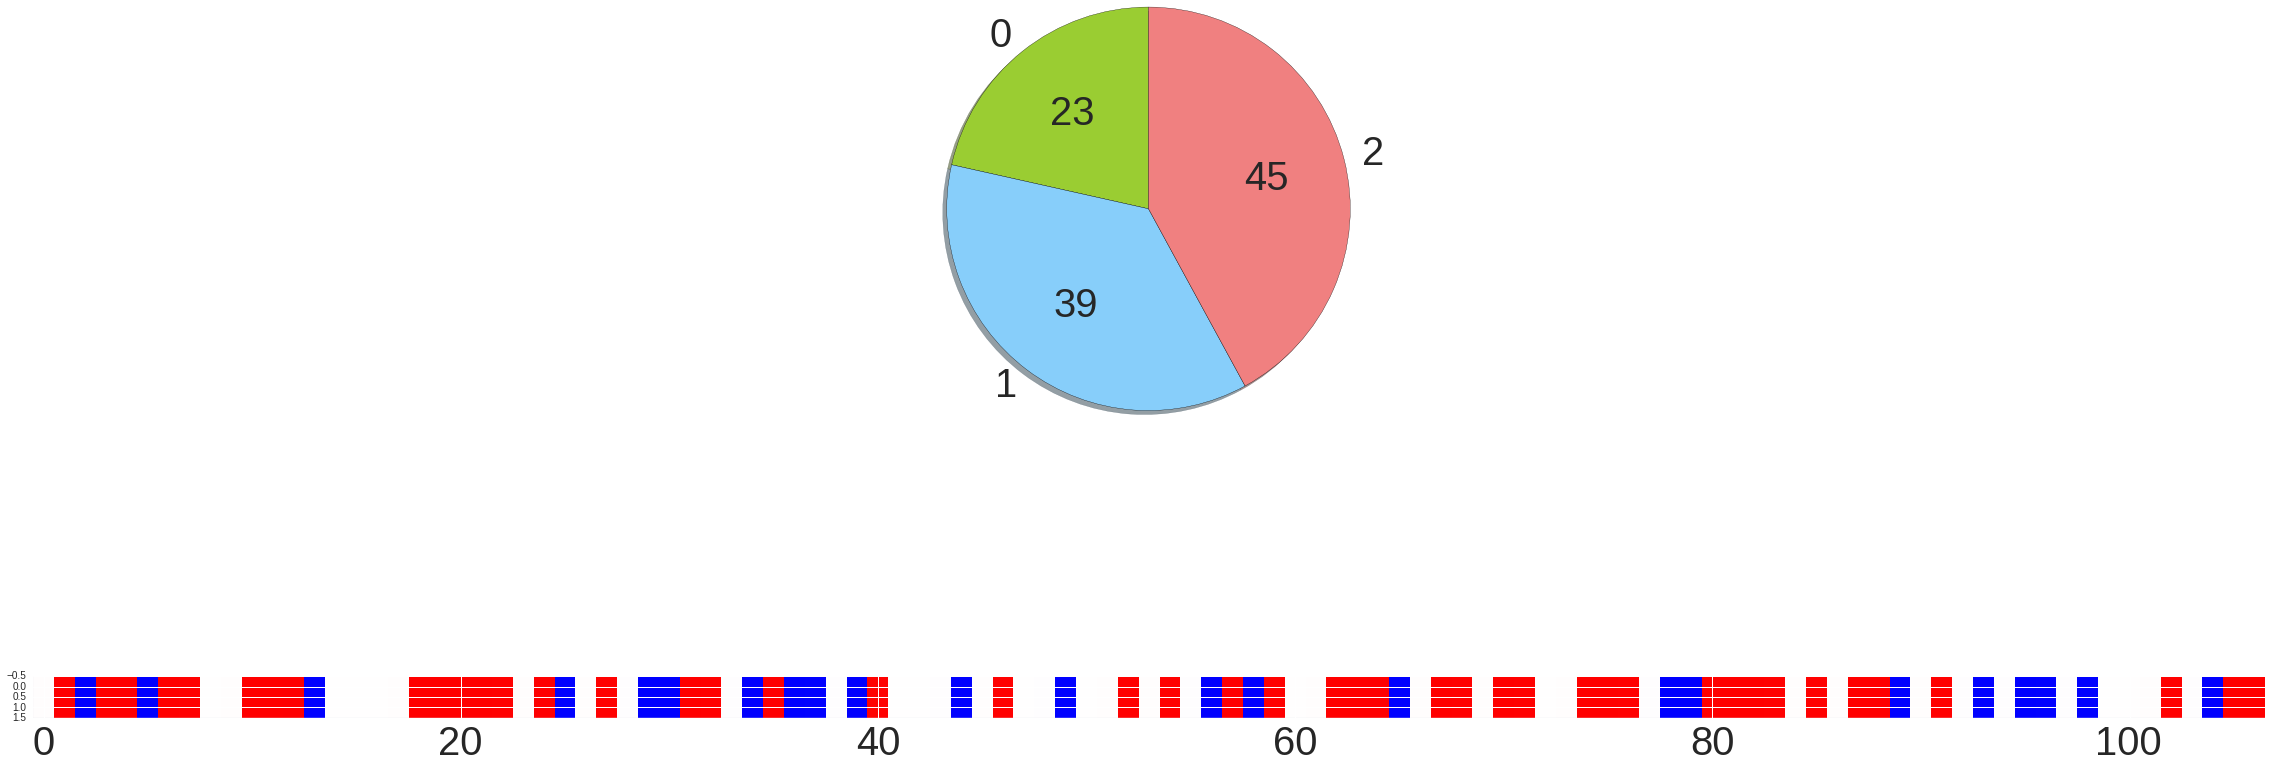

In [38]:
from IPython.html.widgets import interact, SelectMultiple
from IPython.display import display
mutationtypes=pd.unique(df[['mutation','splice']].values.ravel()).tolist()
mutationlist=['NonSyn', 'StopGain', 'NonFrameShiftDelete' ,'FrameShiftInsert', 'StartGain', 'FrameShiftDelete', 'StartLoss', 'SpliceDonor' ,'SpliceAcceptor'
, 'Close_to_SpliceAcceptor', 'Close_to_SpliceDonor', '0']

interact(genpie, MAFdatabase=('kgaf','espaf', 'exacaf', 'any.MAF'),MAFthres=(0,0.1,0.001), CallerGenotype=('gt'),GQthres=(0,100,5), ACthres=(0,100,10),MutationTypes=SelectMultiple(options=mutationlist))

In [40]:
#Sample image of the interation
from IPython.display import Image
Image(url='http://godzilla.uchicago.edu/pages/aashish/1000G/InteractPie.png') 

Now the fun part. The above interactive piechart generation also interactively modifies the dataframe df3, which filters the original dataframe based on the parameter choices above. Now, we can interactively score each of the variants left in df3 using a simple linear scheme. Next, for all the scoring methods defined earlier and called inside genpie, their weights can be interactively set below. These weights are passed on to the genmatrix method, which will then interactively update the sample (rows) and gene/disease(column) probabilities. Again, while the user is not expected to optimize the weights, the interactive feedback regarding how the disease probabilities for the different samples change based on the various features can be crucial for feature engineering as well as developing further automated optimization schemes.  

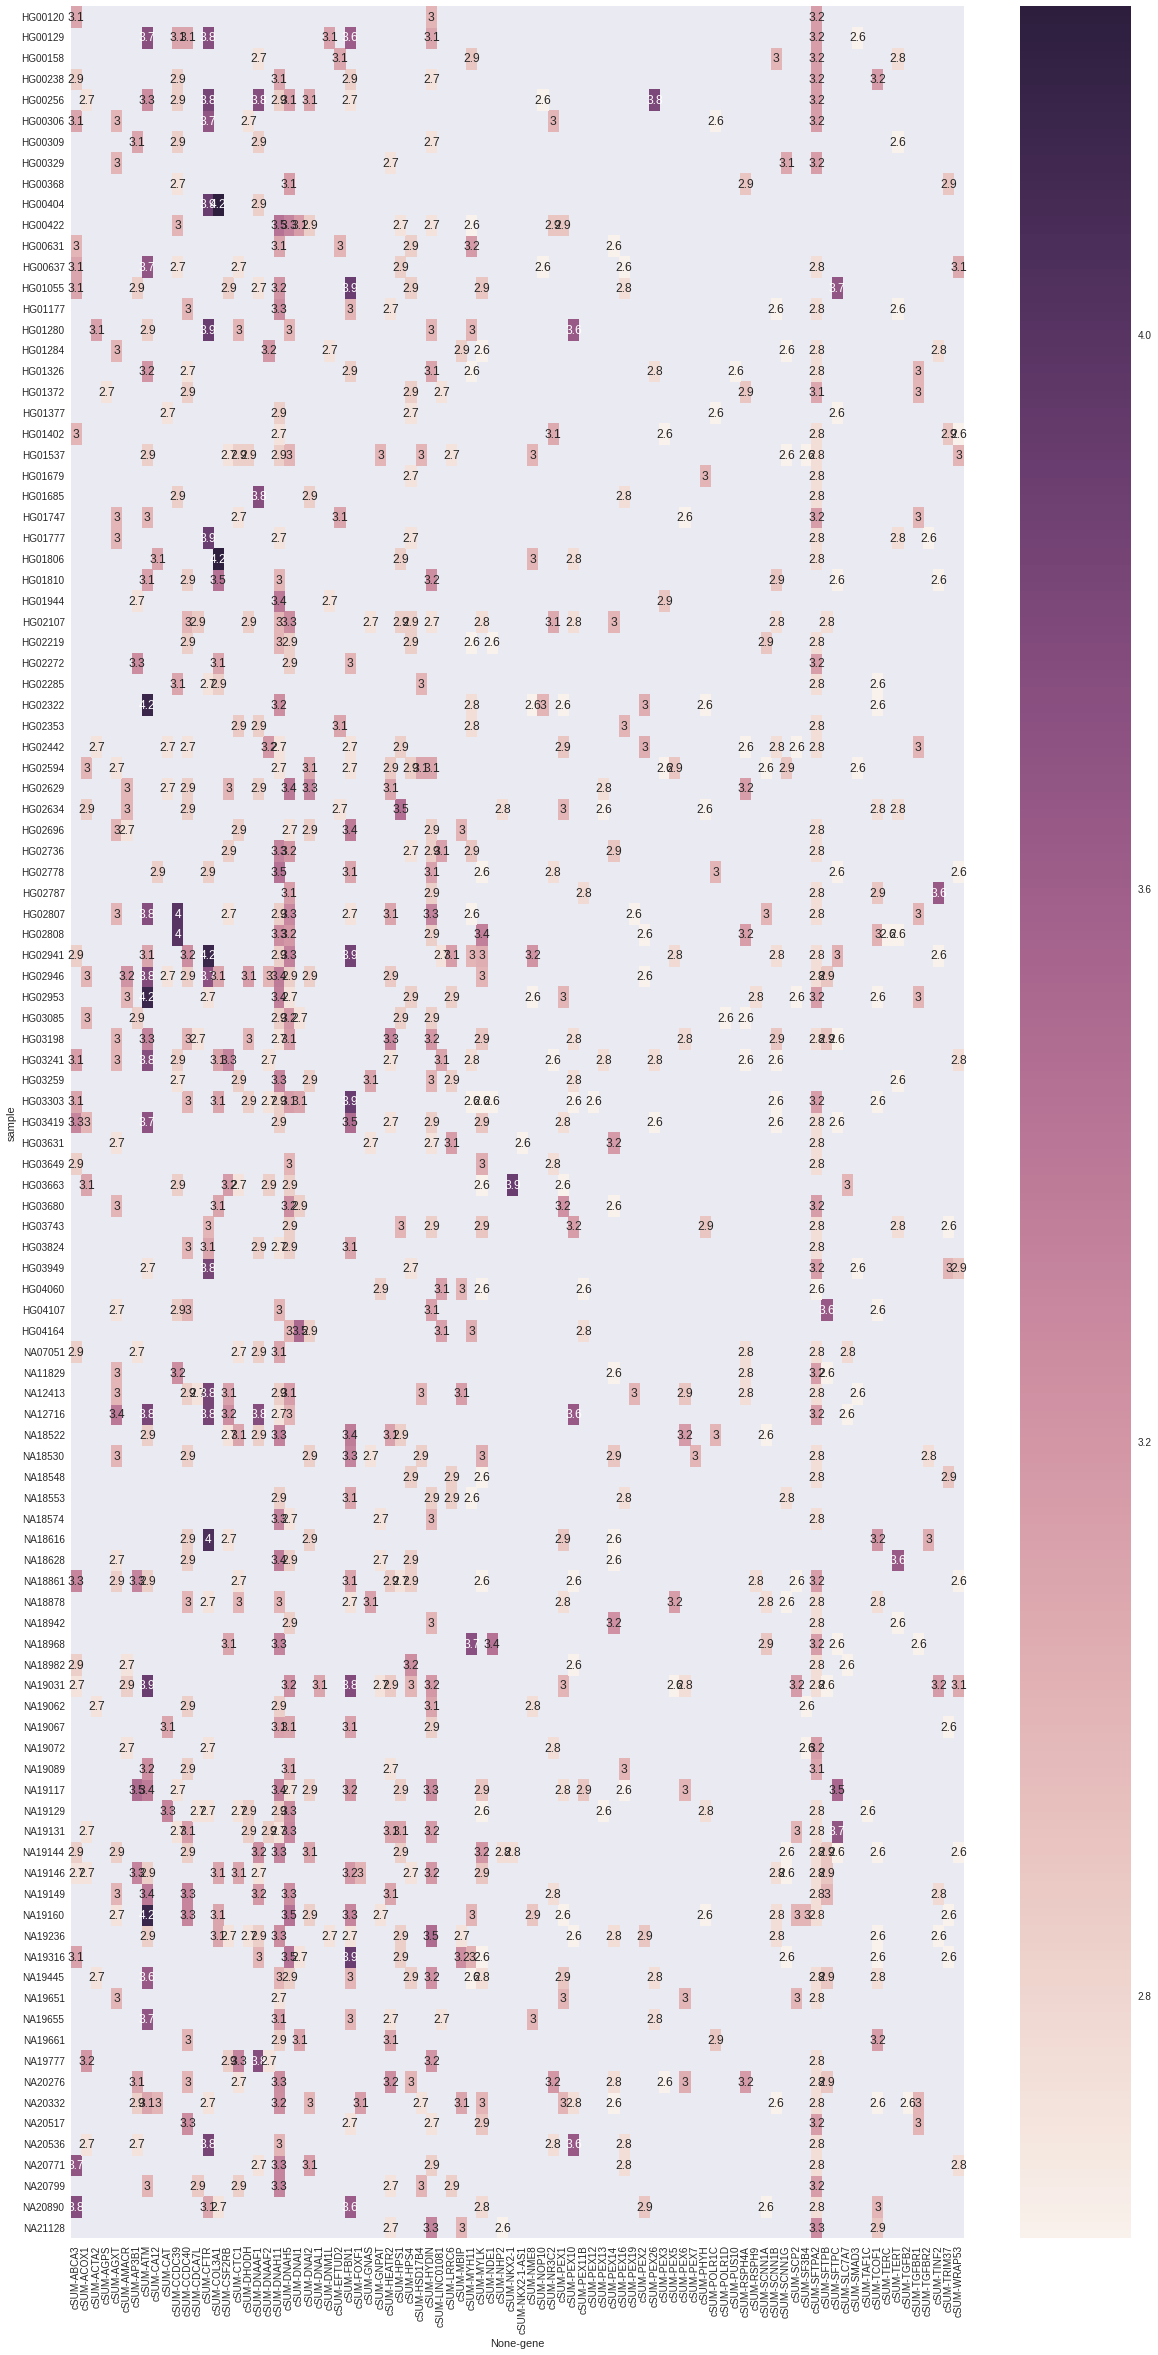

In [41]:
#this method generates the sample - disease/gene matrix of probabilities based on a simple linear model, where the weights are passed in as parameters and can be set interactively below
def genmatrix(cMAFweight,cCallerweight,cGeneweight,cPathogenicityweight,cMuttypeweight,cQualityweight,cDatabaseweight,cInheritanceweight):
    df3['cSUM']=cMAFweight*df3['cMAF']+ \
    cCallerweight* df3['cCaller']+ \
    cGeneweight* df3['cGene'] +  \
    cPathogenicityweight* df3['cPathogenicity']+ \
    cMuttypeweight* df3['cMuttype'] + \
    cQualityweight* df3['cQuality']+ \
    cDatabaseweight* df3['cDatabase']+ \
    cInheritanceweight* df3['cInheritance']


    df4=df3[['sample','gene','cSUM']].groupby(['sample','gene']).mean().unstack()
    df4.fillna(0)

    sns.set()
    from matplotlib import colors
    cmap = colors.ListedColormap(['blue', 'green' ,'red'])
    plt.figure(figsize=(20,40))
    x=sns.heatmap(df4,annot=True)

from IPython.html.widgets import interact_manual
interact(genmatrix, cMAFweight=(0,1,0.1), cCallerweight=(0,1,0.1), cGeneweight=(0,1,0.1), cPathogenicityweight=(0,1,0.1), cMuttypeweight=(0,1,0.1), cDatabaseweight=(0,1,0.1),cQualityweight=(0,1,0.1),cInheritanceweight=(0,1,0.1))

In [42]:
#Sample image of the interation
from IPython.display import Image
Image(url='http://godzilla.uchicago.edu/pages/aashish/1000G/InteractMatrix.png') 